In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skfeature.function.information_theoretical_based import MRMR

pd.set_option('display.max_columns', None)

In [2]:
signal = pd.read_csv("signal.csv", sep = ";")
bkg = pd.read_csv("background.csv", sep = ";")


In [3]:
signal = signal.drop(signal.filter(regex='MC').columns, axis=1)
signal = signal.drop(signal.filter(regex='Weight').columns, axis=1)
signal = signal.drop(signal.filter(regex='Corsika').columns, axis=1)
signal = signal.drop(signal.filter(regex='I3EventHeader').columns, axis=1)
signal = signal.drop(signal.filter(regex='end').columns, axis=1)
signal = signal.drop(signal.filter(regex='start').columns, axis=1)
signal = signal.drop(signal.filter(regex='time').columns, axis=1)
signal = signal.drop(signal.filter(regex='NewID').columns, axis=1)
signal = signal.drop('label', axis=1)

In [4]:
bkg = bkg.drop(bkg.filter(regex='MC').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='Weight').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='Corsika').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='I3EventHeader').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='end').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='start').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='time').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='NewID').columns, axis=1)
bkg = bkg.drop('label', axis=1)

In [5]:
signal.replace([np.inf, -np.inf], np.nan)
signal.dropna(axis = 'columns', inplace = True)
signal = signal.drop(signal.std()[(signal.std() == 0)].index, axis=1)
#signal.dropna(inplace = True)

bkg.replace([np.inf, -np.inf], np.nan)
bkg.dropna(axis = 'columns', inplace = True)
bkg = bkg.drop(bkg.std()[(bkg.std() == 0)].index, axis=1)
#bkg.dropna(inplace = True)

In [6]:
bcol = bkg.columns
scol = signal.columns

In [7]:
for att in scol:
    if att not in bcol:
        signal.drop(att, axis=1, inplace = True)
    
for att in bcol:
    if att not in scol:
        bkg.drop(att, axis=1, inplace = True)

In [8]:
import scipy.io
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.metrics import jaccard_score

In [9]:
sig_label = np.zeros(signal.shape[0])
bkg_label = np.ones(bkg.shape[0])

In [10]:
combined_df = pd.concat([signal, bkg], ignore_index=True)
combined_label = np.append(sig_label, bkg_label)

In [11]:
combined_df.insert(114, 'label', combined_label)
shuffled = combined_df.sample(frac = 1)

In [12]:
y = shuffled['label']
X = shuffled.drop('label', axis=1)

In [13]:
from sklearn import (
    ensemble, linear_model, neighbors, svm, tree, naive_bayes,
    gaussian_process, neural_network, dummy)
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from tqdm import tqdm
model = ensemble.RandomForestClassifier(n_estimators=100)
model.get_params()
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
# Anzahl der features die wir nehmen wollen
N_feat = 20
X_new = SelectKBest(score_func=f_classif, k=N_feat)
d_fit = X_new.fit(X_train, y_train)
# generiere scores die die güte des features angeben
scores = d_fit.scores_
# sortiere nach größe...
sorted_scores = sorted(scores, reverse=True)
args_max = np.argsort(scores)[::-1]
# print(args_max)
# lese die N_feat wichtigsten features aus und speichere sie weg
features = []
for i in range(N_feat):
    features.append(X.columns.tolist()[args_max[i]])
print(features)
# werfe aus den trainingsdaten und testdaten alle features bis auf die wichtigsten raus
X_train = X_train.loc[:, features]
X_test = X_test.loc[:, features]

['LineFit_TTParams.lf_vel_z', 'HitStatisticsValues.z_travel', 'LineFit_TT.zenith', 'SplineMPEFitParams.rlogl', 'MuEXAngular4.zenith', 'SplineMPETruncatedEnergy_SPICEMie_AllDOMS_Muon.zenith', 'SplineMPEMuEXDifferential.zenith', 'SplineMPE.zenith', 'SplineMPETruncatedEnergy_SPICEMie_AllBINS_Muon.zenith', 'MPEFitHighNoise.zenith', 'MPEFitParaboloid.zenith', 'MPEFitParaboloidFitParams.zenith', 'SplineMPEDirectHitsA.n_dir_doms', 'SplineMPEDirectHitsA.n_dir_strings', 'SplineMPEDirectHitsC.dir_track_length', 'SplineMPETruncatedEnergy_SPICEMie_AllDOMS_MuEres.value', 'SplineMPEDirectHitsC.n_dir_doms', 'HitStatisticsValues.cog_z_sigma', 'HitStatisticsValues.z_sigma', 'NewAtt.DirectEllipse']


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
# trainiere den lerner
model.fit(X_train, y_train)
# sage die labels vorher
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred)

In [17]:
#print(roc_auc_score(y_test, y_pred))
#print(r2_score(y_test, y_pred))

RFC_precision = precision_score(y_test, model.predict(X_test))
RFC_eff = accuracy_score(y_test, model.predict(X_test))
print('RFC accuracy score(sklearn) = ', RFC_eff)
print('RFC precision score(sklearn) = ', RFC_precision)
rfc_Jscore = jaccard_score(y_test, model.predict(X_test))
print('jaccard score, RFC: ', rfc_Jscore)

RFC accuracy score(sklearn) =  0.93425
RFC precision score(sklearn) =  0.9224749327463928
jaccard score, RFC:  0.8776174965100046


In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.spatial import distance
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import accuracy_score

class KNN:
    def __init__(self, k):
        self.k = k


    def euc(self, a, b):
        return distance.euclidean(a, b)


    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

        
    def predict(self, X):
        pred = []
        # row_count = 0
        for row in X: # iteriere durch jedes event
            # label = orte mit kleinstem abstand
            label = self.closest_points(row, self.X_train)
            # pred.append(prediction)
            N_sig = 0
            N_bg = 0
            for i in label:
                if self.y_train[i] == 0:
                    N_sig += 1
                else:
                    N_bg += 1
            if N_sig >= N_bg: # wenn label = signal ist dann 0 ( weil 0 = signal heisst)
                pred.append(0)
            else:
                pred.append(1) # sonst 1 appenden da 1 = bg
            # if row_count % 10000 == 0:
                # print(row_count)
            # row_count += 1
        return pred

    
    def closest_points(self, row, X):
        index = [] # speichere hier die besten indizes
        distances = [] # alle distanzen
        distances = distance.cdist([row], X, 'euclidean')
        
        sort_dist = np.argsort(distances) # sortiere die distancen und gibt die k kleinsten zurueck
        for j in range(self.k):
            index.append(sort_dist[0][j])

        return index

In [19]:
nn = 20
knn = KNN(nn)
# daten muessen np arrays sein
X_trn = np.array(X_train)
y_trn = np.array(y_train)
X_t = np.array(X_test)
y_t = np.array(y_test)

knn_fit = knn.fit(X_trn, y_trn)
knn_pred = knn.predict(X_t)

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.spatial import distance
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import accuracy_score

knn_roc_score = roc_auc_score(y_test, knn_pred)
#print('roc_auc score (knn): ', knn_roc_score)

y_true = y_t.tolist()

tp = 0
fp = 0
fn = 0
tn = 0
for i in range(len(y_true)):
    if knn_pred[i] == y_true[i] and knn_pred[i] == 0:
        tp += 1
    if knn_pred[i] == 0 and y_true[i] == 1:
        fp += 1
    if knn_pred[i] == 1 and y_true[i] == 0:
        fn += 1
    if knn_pred[i] == y_true[i] and knn_pred[i] == 1:
        tn += 1

# print('tp: ', tp, 'fp: ', fp, 'fn: ', fn, 'tn:', tn)

Eff = tp / (tp + fn)
P = tp / (tp + fp)
S = tp / np.sqrt(tp + tn)
accuracy = (tp + tn) / (tp + fp + tn + fn)

print('for kNN:')
print('accuracy score(sklearn) = ', accuracy_score(knn_pred, y_true))
print('Eff: ', Eff)
print('Purity: ', P)
print('Signifikanz: ', S)
print('Accuracy: ', accuracy)

for kNN:
accuracy score(sklearn) =  0.879125
Eff:  0.8733515799950237
Purity:  0.8845766129032258
Signifikanz:  41.853984367007584
Accuracy:  0.879125


In [21]:
# knn von sklearn:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=nn)
knn_clf.fit(X_train, y_train)
PRED_knn = knn_clf.predict_proba(X_test)
PRED_knn = PRED_knn[:, 1]
fpr2, tpr2, thr2 = roc_curve(y_test, PRED_knn)

In [22]:
knn_precision = precision_score(y_true, knn_clf.predict(X_test))
knn_eff = accuracy_score(y_true, knn_clf.predict(X_test))
print('KNN accuracy score(sklearn) = ', knn_eff)
print('KNN precision score(sklearn) = ', knn_precision)
knn_Jscore = jaccard_score(y_true, knn_clf.predict(X_test))
print('jaccard score, kNN: ', knn_Jscore)

KNN accuracy score(sklearn) =  0.879125
KNN precision score(sklearn) =  0.8737599206349206
jaccard score, kNN:  0.7846325167037862


In [23]:
# naive bayes:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
NB_pred = clf.predict_proba(X_test)
NB_pred = NB_pred[:, 1]
fpr3, tpr3, thr3 = roc_curve(y_test, NB_pred)

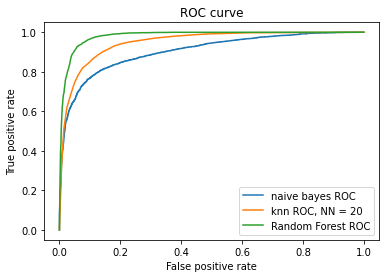

In [24]:
plt.figure(1)
plt.plot(fpr3, tpr3, label='naive bayes ROC')
plt.plot(fpr2, tpr2, label='knn ROC, NN = {}'.format(nn))
plt.plot(fpr1, tpr1, label='Random Forest ROC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [25]:
NB_precision = precision_score(y_true, clf.predict(X_test))
NB_eff = accuracy_score(y_true, clf.predict(X_test))
print('NB accuracy score(sklearn) = ', NB_eff)
print('NB precision score(sklearn) = ', NB_precision)
NB_Jscore = jaccard_score(y_true, clf.predict(X_test))
print('jaccard score, NB: ', NB_Jscore)

NB accuracy score(sklearn) =  0.797625
NB precision score(sklearn) =  0.753978494623656
jaccard score, NB:  0.6840975609756098
